In [1]:
import matplotlib.pyplot as plt
from pydrake.all import (BasicVector, LeafSystem, DiagramBuilder, Simulator, LogOutput, ConstantVectorSource, 
                         LinearSystem)
import numpy as np
import scipy.linalg as la

In [3]:
# Define the system.
class CTYuntian(LeafSystem):
    def __init__(self, A, B, C):
        LeafSystem.__init__(self)
        
        num_state = A.shape[0]
        num_input = B.shape[1]
        num_output = C.shape[0]
        
        # Define the state vector
        self.DeclareContinuousState(num_state)  
        # Define the input
        self.DeclareVectorInputPort("u", BasicVector(num_input))
        # Define the output
        self.DeclareVectorOutputPort("y", BasicVector(num_output), self.CalcOutputY, set([self.all_state_ticket()])) 
        
        self._A = A
        self._B = B
        self._C = C
        
    def DoCalcTimeDerivatives(self, context, derivatives):
        # Get the state vector
        x = context.get_continuous_state_vector().CopyToVector()
        # Get the input
        u = self.get_input_port(0).Eval(context)
    
        xdot = self._A @ x + self._B @ u
#       derivatives.get_mutable_vector().SetFromVector(xdot)
        derivatives.get_mutable_vector().SetFromVector(xdot)
        
    # y = Cx 
    def CalcOutputY(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        y = self._C @ x
        output.SetFromVector(y)

Text(0, 0.5, 'y(t)')

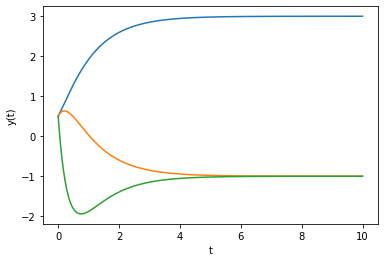

In [4]:
# testing 
A = np.array([[0, 1, 0], [0, 0, 1],[-6, -11, -6]])    
B = np.array([1, 1, 1]).reshape(3,1)
C = np.identity(3)
D = np.zeros((3,1))

# Create a simple block diagram containing our system.
builder = DiagramBuilder()
mySys = builder.AddSystem(CTYuntian(A, B, C))
stepInput = builder.AddSystem(ConstantVectorSource([0]))  #step-input
builder.Connect(stepInput.get_output_port(0), mySys.get_input_port(0))  #connect input to my system
logger_output = LogOutput(mySys.get_output_port(0), builder)
logger_input = LogOutput(stepInput.get_output_port(0), builder)
diagram = builder.Build()


# Set the initial conditions, x1(0), x2(0), x3(0)
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.5, 0.5, 0.5])

# Create the simulator
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
plt.figure()
plt.plot(logger_output.sample_times(), logger_output.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')